In [0]:
# from google.colab import drive
# drive.mount("/content/drive")

In [0]:
# !unzip -q "ships_segmentation_dataset.zip"

In [3]:
pwd

'/content'

In [4]:
cd /content/drive/My\ Drive

/content/drive/My Drive


In [5]:
import tensorflow as tf 
import os
import csv
import random
import PIL
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
#from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
from PIL import Image
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.morphology import label
from skimage.util import montage
from skimage.segmentation import mark_boundaries

from keras.models import Model, load_model, model_from_json
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

Using TensorFlow backend.


In [0]:
baseDir = "/content/drive/My Drive/Ship Segmentation Dataset/Dataset/"
TRAIN_DATA_PATH = baseDir + "train_data/"
TEST_DATA_PATH = baseDir + "test_data/"
IMAGE_WIDTH = 768
IMAGE_HEIGHT = 768
IMAGE_CHANNELS = 3
SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT)

# variables for resizing of image
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3


In [0]:
# getting all the masks of a particular image in all_mask python dictionary

all_mask = {}
with open(baseDir + "train_segmentations.csv", 'r') as inp:
    for row in csv.reader(inp, delimiter = ','):
        img = row[0]
        mask = row[1]
        if(len(mask) == 0):
            all_mask[img] = []
        elif (img in all_mask):
            all_mask[img].append(mask)
        else:
            all_mask[img] = []
            all_mask[img].append(mask)

In [8]:
print(len(all_mask))

5749


In [0]:
# for mask_ in all_mask.values():
#   print(len(mask_))

In [0]:
def rle_decode(mask_rle, shape = SHAPE):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def masks_as_image(in_mask_list, shape=SHAPE):
    all_masks = np.zeros(shape, dtype = np.int16)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    # resizing image(mask) to 128X128
    all_masks.resize(SHAPE)
    all_masks = Image.fromarray(all_masks)
    mywidth = IMG_WIDTH
    wpercent = (mywidth/float(all_masks.size[0]))
    hsize = int((float(all_masks.size[1])*float(wpercent)))
    all_masks = all_masks.resize((mywidth,hsize), PIL.Image.ANTIALIAS)
    all_masks = np.asarray(all_masks)

    return np.expand_dims(all_masks, -1)

def shows_decode_encode(image_id, path=TRAIN_DATA_PATH):
    fig, axarr = plt.subplots(1, 3, figsize = (10, 5))
    # resizing imge to 128X128
    mywidth = IMG_WIDTH
    img = Image.open(path + image_id)
    wpercent = (mywidth/float(img.size[0]))
    hsize = int((float(img.size[1])*float(wpercent)))
    img = img.resize((mywidth,hsize), PIL.Image.ANTIALIAS)

    rgb_img = np.asarray(img)

    rle = all_mask[image_id]
    seg_img = masks_as_image(rle)

    axarr[0].imshow(rgb_img)
    axarr[0].set_title('Image')

    axarr[1].imshow(seg_img[:, :, 0])
    axarr[1].set_title('Segmentation')

    axarr[2].imshow(mark_boundaries(rgb_img, seg_img[:,:,0].astype(int)))
    axarr[2].set_title('Outlined Ship')



def show_segmentations(img, mask):
    fig, axarr = plt.subplots(1, 3, figsize = (10, 5))

    # resizing imge to 128X128
    mywidth = IMG_WIDTH
    img = Image.fromarray(img)
    wpercent = (mywidth/float(img.size[0]))
    hsize = int((float(img.size[1])*float(wpercent)))
    img = img.resize((mywidth,hsize), PIL.Image.ANTIALIAS)

    rgb_img = np.asarray(img)

    mask = np.squeeze(mask) # for eliminating 1 in shape

    axarr[0].imshow(rgb_img)
    axarr[0].set_title('Image')

    axarr[1].imshow(mask)
    axarr[1].set_title('Segmentation')

    axarr[2].imshow(mark_boundaries(rgb_img, mask.astype(int)))
    axarr[2].set_title('Outlined Ship')

In [0]:
# shows_decode_encode('000155de5.jpg')

In [12]:
train_ids = os.listdir(TRAIN_DATA_PATH)
test_ids = os.listdir(TEST_DATA_PATH)
num_test_images = 1500
X_train = np.zeros((len(train_ids), IMG_WIDTH, IMG_HEIGHT, IMAGE_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_WIDTH, IMG_HEIGHT, 1), dtype=np.bool)
X_test = np.zeros((num_test_images, IMG_WIDTH, IMG_HEIGHT, IMAGE_CHANNELS), dtype=np.uint8)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

(5749, 128, 128, 3)
(5749, 128, 128, 1)
(1500, 128, 128, 3)


In [13]:
# resizing training images and masks
'''
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_DATA_PATH + id_
    img = imread(path)[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask_list = all_mask[id_]
    mask = masks_as_image(mask_list)
    Y_train[n] = mask
'''

"\nfor n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   \n    path = TRAIN_DATA_PATH + id_\n    img = imread(path)[:,:,:IMG_CHANNELS]  \n    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)\n    X_train[n] = img  #Fill empty X_train with values from img\n    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)\n    mask_list = all_mask[id_]\n    mask = masks_as_image(mask_list)\n    Y_train[n] = mask\n"

In [14]:
# creating and resizing np arrays of test images
'''
for n, id_ in tqdm(enumerate(test_ids), total=num_test_images):  
    if(n >= 1500):
        break 
    path = TEST_DATA_PATH + id_
    img = imread(path)[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img  #Fill empty X_test with values from img

'''

"\nfor n, id_ in tqdm(enumerate(test_ids), total=num_test_images):  \n    if(n >= 1500):\n        break \n    path = TEST_DATA_PATH + id_\n    img = imread(path)[:,:,:IMG_CHANNELS]  \n    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)\n    X_test[n] = img  #Fill empty X_test with values from img\n\n"

In [15]:

# np.save("/content/drive/My Drive/Ship Segmentation Dataset/Dataset/X_train_data", X_train)
# np.save("/content/drive/My Drive/Ship Segmentation Dataset/Dataset/Y_train_data", Y_train)
# np.save("/content/drive/My Drive/Ship Segmentation Dataset/Dataset/X_test_data", X_test)

X_train = np.load("/content/drive/My Drive/Ship Segmentation Dataset/Dataset/X_train_data.npy")
Y_train = np.load("/content/drive/My Drive/Ship Segmentation Dataset/Dataset/Y_train_data.npy")
X_test = np.load("/content/drive/My Drive/Ship Segmentation Dataset/Dataset/X_test_data.npy")

# idx = random.randint(0, len(X_test))
# imshow(X_test[idx])
# plt.plot()

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)


(5749, 128, 128, 3)
(5749, 128, 128, 1)
(1500, 128, 128, 3)


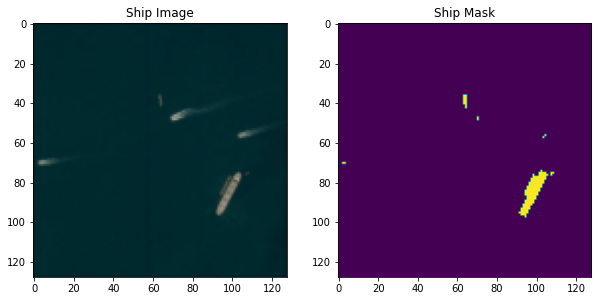

In [16]:
image_x = random.randint(0, len(train_ids))
n = 1
for i in range(n):
  fig, axarr = plt.subplots(1, 2, figsize = (10, 5))
  axarr[0].imshow(X_train[i])
  axarr[0].set_title("Ship Image")
  axarr[1].imshow(np.squeeze(Y_train[i]))
  axarr[1].set_title("Ship Mask")
  plt.show()

In [17]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [51]:
import h5py
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/Ship Segmentation Dataset/Dataset/', verbose=1, save_best_only=True, save_weights_only=False)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

history = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=5, callbacks=callbacks)

# model.save(baseDir + "model.h5")



Epoch 1/5
324/324 [==============================] - 41s 126ms/step - loss: 0.0099 - accuracy: 0.9970 - val_loss: 0.0023 - val_accuracy: 0.9994
Epoch 2/5
324/324 [==============================] - 41s 126ms/step - loss: 0.0090 - accuracy: 0.9973 - val_loss: 0.0021 - val_accuracy: 0.9994
Epoch 3/5
324/324 [==============================] - 41s 126ms/step - loss: 0.0084 - accuracy: 0.9974 - val_loss: 0.0029 - val_accuracy: 0.9993
Epoch 4/5
324/324 [==============================] - 41s 126ms/step - loss: 0.0082 - accuracy: 0.9975 - val_loss: 0.0019 - val_accuracy: 0.9995
Epoch 5/5
324/324 [==============================] - 41s 126ms/step - loss: 0.0078 - accuracy: 0.9975 - val_loss: 0.0020 - val_accuracy: 0.9995


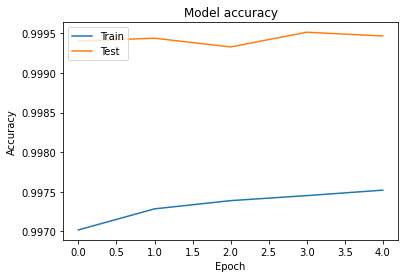

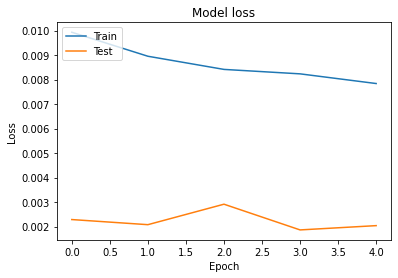

In [53]:
# print(history.history)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [22]:
scores = model.evaluate(X_train, Y_train, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 99.73%


In [0]:
# # serialize model to JSON
# model_json = model.to_json()
# with open(baseDir + "model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights(baseDir + "model.h5")
# print("Saved model to disk")

In [54]:
idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

47/47 [==============================] - 3s 66ms/step


(1500, 128, 128, 1)
(1500, 128, 128, 1)


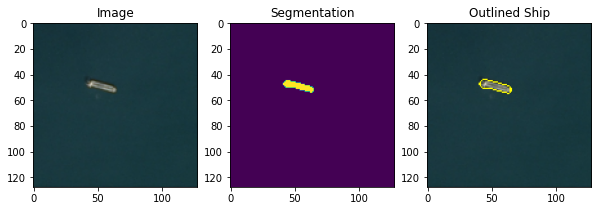

In [65]:
print(preds_test.shape)
print(preds_test_t.shape)

ix = random.randint(0, len(preds_test_t))
show_segmentations(X_test[ix], preds_test_t[ix])